In [1]:
#!pip3 install numpy pandas seaborn matplotlib sklearn

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
%matplotlib inline

#sns.set_palette("Accent")
sns.set_theme(style="darkgrid")

# Entrada de dados

## Treino

In [4]:
df_train = pd.read_csv(os.path.join(os.getcwd(), "data", "train.csv"))
df_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.00,0,0,PC 17477,69.3000,B35,C
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.00,0,1,392091,9.3500,NaN,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.00,0,0,PC 17601,27.7208,NaN,C
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.00,0,0,PC 17590,50.4958,A24,S
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.00,0,0,349203,7.8958,NaN,S
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.00,0,0,3101264,6.4958,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.00,1,0,36973,83.4750,C83,S
852,853,0,3,"Boulos, Miss. Nourelain",female,9.00,1,1,2678,15.2458,NaN,C


In [5]:
print(f"O Conjunto de treino é composto por {len(df_train)} passageiros")

O Conjunto de treino é composto por 891 passageiros


## Teste

In [6]:
df_test = pd.read_csv(os.path.join(os.getcwd(), "data", "test.csv"))
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Analisando os dados de entrada

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### As colunas "Cabin", "Age" e "Embarked" apresentam valores nulos

### A idade dos passageiros influencia sua sobrevivencia?

In [8]:
df = df_train
mean_age = round(df["Age"].mean(), 0) 
print(f"Preenchendo os valores nulos de idade com o valor médio {mean_age} ")
df["Age"].replace(np.nan, mean_age, inplace=True)
df["Age"] = df["Age"].astype(int)

Preenchendo os valores nulos de idade com o valor médio 30.0 


<AxesSubplot:xlabel='Age', ylabel='Count'>

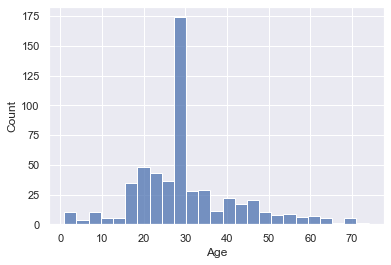

In [9]:
# Inserir titulo e formatar a figura
sns.histplot(data=df.query("Survived == 0"), x="Age")

<AxesSubplot:xlabel='Age', ylabel='Count'>

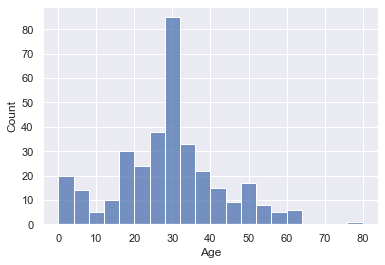

In [10]:
sns.histplot(data=df.query("Survived == 1"), x="Age")

### A classe dos passageiros influencia sua sobrevivencia?

In [11]:
df = pd.concat([df_train["Survived"], df_train["Pclass"]], axis=1)
df = pd.melt(df, id_vars=["Survived"], value_name="Pclass")
df.drop(["variable"], axis=1, inplace=True)
df.head()

C:\Users\vinic\AppData\Local\Temp\ipykernel_5676\1628114229.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df = pd.melt(df, id_vars=["Survived"], value_name="Pclass")


,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

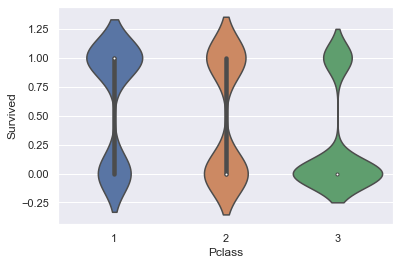

In [12]:
sns.violinplot(y="Survived", x="Pclass", data=df)

### O sexo dos passageiros influencia sua sobrevivencia?

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

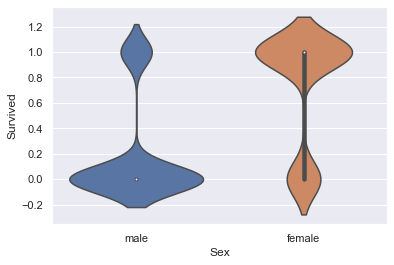

In [14]:
sns.violinplot(y="Survived", x="Sex", data=df)

### O número de familiares abordo influencia sua sobrevivencia?

In [15]:
df = pd.concat([df_train["Survived"], df_train["SibSp"]], axis=1)
df.head()

,Survived,SibSp
0,0,1
1,1,1
2,1,0
3,1,1
4,0,0


<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

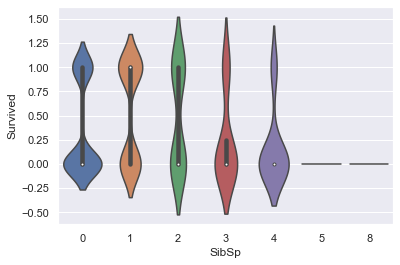

In [16]:
sns.violinplot(y="Survived", x="SibSp", data=df)

In [17]:
df = pd.concat([df_train["Survived"], df_train["Parch"]], axis=1)
df.head()

,Survived,Parch
0,0,0
1,1,0
2,1,0
3,1,0
4,0,0


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

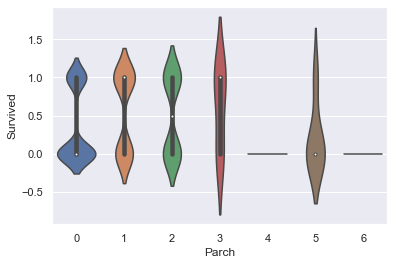

In [18]:
sns.violinplot(y="Survived", x="Parch", data=df)

# Train, test 

In [63]:
df = pd.read_csv(os.path.join(os.getcwd(), "data", "train.csv"))

In [64]:
mean_age = round(df["Age"].mean(), 0) 
print(f"Preenchendo os valores nulos de idade com o valor médio {mean_age} ")
df["Age"].replace(np.nan, mean_age, inplace=True)

Preenchendo os valores nulos de idade com o valor médio 30.0 


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
